# Análisis Exploratorio
****
**Equipo 5 BEDU**
* Eduardo Alán Hernández Villasana
* Cristopher Arvizu Cano
* José Antonio Aguilar Téllez

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import warnings
import os
warnings.simplefilter(action='ignore', category=FutureWarning)

# Librerías para Modelo de Regresión Lineal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

# Descripción de cada dato

In [2]:
df_desc = pd.read_csv('https://raw.githubusercontent.com/EduHdzVillasana/Analisis_Crimen_Chicago_BEDU/main/documentacion_Crimenes.csv', sep=',', encoding='latin1')
#df_desc = df_desc.drop(columns='Unnamed: 3')
df_desc.style.set_properties(subset=['Description'], **{'width': '300px'})

,Column Name,Description,Type
0,ID,Unique identifier for the record.,Number
1,Case Number,"The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.",Plain Text
2,Date,Date when the incident occurred. this is sometimes a best estimate.,Date & Time
3,Block,"The partially redacted address where the incident occurred, placing it on the same block as the actual address.",Plain Text
4,IUCR,The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.,Plain Text
5,Primary Type,The primary description of the IUCR code.,Plain Text
6,Description,"The secondary description of the IUCR code, a subcategory of the primary description.",Plain Text
7,Location Description,Description of the location where the incident occurred.,Plain Text
8,Arrest,Indicates whether an arrest was made.,Checkbox
9,Domestic,Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.,Checkbox


## Base de datos

## Importante (Antes de correr el Notebook)

Si gustas correr todo el notebook, te compartimos el link donde alojamos los datos de crimenes de Chicago. Antes de correrlo te rrecomendamos elegir el directorio donde alojes los datos que te compartimos en nuestro caso decidimos utilizar  **'/content/drive/MyDrive/', esperamos que esta información te sea util y te permite navegar de una mejor manera dentro de este notebook. Como ultima recomendación debo avisarte que la base de datos tiene un size de 7,000,000 aproximadamente por lo que toma tiempo en la visualización de mapas, clustering y wordCloud.

link DataSet:

https://drive.google.com/drive/folders/1D_zLbpVue7U8WzSGy7DRSqDXr7KQYMbY

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#df_raw = pd.read_csv('/content/drive/MyDrive/Datos Análisis del Crimen en Chicago/Crimes_-_2001_to_Present.csv')
df = pd.read_csv('/content/drive/MyDrive/Datos Análisis del Crimen en Chicago/Crimes_2001-2021_clean.csv', index_col=0, )
#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BEDU/Datos Análisis del Crimen en Chicago/Crimes_2001-2021_clean.csv', index_col=0, )

In [ ]:
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,2015-09-05 13:30:00,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9.0,12.0,61.0,08B,1165074.0,1875917.0,2015,2018-02-10 15:50:01,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,2015-09-04 11:30:00,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,1511,15.0,29.0,25.0,06,1138875.0,1904869.0,2015,2018-02-10 15:50:01,41.895080,-87.765400,"(41.895080471, -87.765400451)"
3,10224740,HY411595,2015-09-05 12:45:00,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14.0,35.0,21.0,18,1152037.0,1920384.0,2015,2018-02-10 15:50:01,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,2015-09-05 13:00:00,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,1522,15.0,28.0,25.0,08A,1141706.0,1900086.0,2015,2018-02-10 15:50:01,41.881903,-87.755121,"(41.881903443, -87.755121152)"
5,10224742,HY411435,2015-09-05 10:55:00,082XX S LOOMIS BLVD,0610,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,614,6.0,21.0,71.0,05,1168430.0,1850165.0,2015,2018-02-10 15:50:01,41.744379,-87.658431,"(41.744378879, -87.658430635)"


In [5]:
# No existen los Distritos policiales 21 y 31. 

df = df[df["District"] != 21.0]
df = df[df["District"] != 31.0]

In [6]:
# Algunos delitos registrados salen del área de Chicago

df= df[df["Latitude"] > 41]

In [ ]:
df.dtypes

ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

# Casting fechas y boolean

In [7]:
df['Arrest'] = df['Arrest'].apply(lambda x: 1 if x == True else 0)
df['Domestic'] = df['Domestic'].apply(lambda x: 1 if x == True else 0)

In [8]:
df_typo_crimen = df[['Arrest', 'Domestic']]
df_typo_crimen

,Arrest,Domestic
0,0,1
1,0,0
3,1,0
4,0,1
5,0,0
...,...,...
7312660,0,1
7312662,0,0
7312663,0,0
7312664,0,0


In [9]:
df['Date'] = pd.to_datetime(df.Date)

In [ ]:
df['Date']

0         2015-09-05 13:30:00
1         2015-09-04 11:30:00
3         2015-09-05 12:45:00
4         2015-09-05 13:00:00
5         2015-09-05 10:55:00
                  ...        
7312660   2021-04-17 15:30:00
7312662   2021-04-17 16:00:00
7312663   2021-04-17 19:00:00
7312664   2021-04-17 09:00:00
7312665   2021-04-17 10:11:00
Name: Date, Length: 6628004, dtype: datetime64[ns]

In [ ]:
df.dtypes

ID                               int64
Case Number                     object
Date                    datetime64[ns]
Block                           object
IUCR                            object
Primary Type                    object
Description                     object
Location Description            object
Arrest                           int64
Domestic                         int64
Beat                             int64
District                       float64
Ward                           float64
Community Area                 float64
FBI Code                        object
X Coordinate                   float64
Y Coordinate                   float64
Year                             int64
Updated On                      object
Latitude                       float64
Longitude                      float64
Location                        object
dtype: object

# Estimados de Locación y Variabilidad

In [ ]:
df_estimados = df.copy()

In [ ]:
df_estimados["District"] = df_estimados["District"].apply(lambda x: str(int(x)))

In [ ]:
df_estimados["District"].unique()

array(['9', '15', '14', '6', '10', '12', '8', '16', '5', '2', '4', '22',
       '3', '1', '7', '11', '17', '20', '25', '18', '19', '24'],
      dtype=object)

In [ ]:
df_days = df_estimados.copy()
df_days ["Day"] = df["Date"].apply(lambda x: x.date())

In [ ]:
df_days["Total"] = 1
df_grouped_day = df_days.groupby("Day")["Total"].count()
df_grouped_day.head()

Day
2001-01-01    274
2001-01-02     10
2001-01-03      4
2001-01-05      6
2001-01-06      6
Name: Total, dtype: int64

In [ ]:
mean_cases_by_day = df_grouped_day.mean()
median_cases_by_day = df_grouped_day.median()
std_cases_by_day = df_grouped_day.std()

In [ ]:
### Mi función summary
def summary(data):
  minimo = data.min()
  Q1 = data.quantile(0.25)
  median = data.median()
  mean = data.mean()
  Q2 = data.quantile(0.5)
  Q3 = data.quantile(0.75)
  maximo = data.max()
  IQR = Q3 - Q1
  std = data.std()
  resumen = {'minimo': minimo, 'Q1': Q1, 'mediana':median,'Q2':Q2,'Q3':Q3,'max':maximo,'IQR':IQR, 'media':mean, 'std':std}
  return resumen

In [ ]:
data_summary = summary(df_grouped_day)
IQR = data_summary["IQR"]
Q1 = data_summary["Q1"]
Q2 = data_summary["Q2"]
Q3 = data_summary["Q3"]

In [ ]:
print(f"En promedio hay {round(mean_cases_by_day,2)} casos reportados por día")
print(f"La mediana de los casos por día es {round(median_cases_by_day,2)} casos reportados por día")
print(f"El rango intercuartílico de los casos por día es de {IQR} ")
print(f"El Percentil 25 o Primer Cuartil es {Q1}")
print(f"El Percentil 50 o Segundo Cuartil es {Q2}")
print(f"El Percentil 75 o Tercer Cuartil es {Q3}")

En promedio hay 894.5 casos reportados por día
La mediana de los casos por día es 887.0 casos reportados por día
El rango intercuartílico de los casos por día es de 460.0 
El Percentil 25 o Primer Cuartil es 702.0
El Percentil 50 o Segundo Cuartil es 887.0
El Percentil 75 o Tercer Cuartil es 1162.0


# Visualización de datos: Distribuciones

In [ ]:
df['Primary Type'].unique()

array(['BATTERY', 'THEFT', 'NARCOTICS', 'ASSAULT', 'BURGLARY', 'ROBBERY',
       'OTHER OFFENSE', 'CRIMINAL DAMAGE', 'WEAPONS VIOLATION',
       'DECEPTIVE PRACTICE', 'CRIMINAL TRESPASS', 'MOTOR VEHICLE THEFT',
       'SEX OFFENSE', 'INTERFERENCE WITH PUBLIC OFFICER',
       'OFFENSE INVOLVING CHILDREN', 'PUBLIC PEACE VIOLATION',
       'PROSTITUTION', 'GAMBLING', 'CRIM SEXUAL ASSAULT',
       'LIQUOR LAW VIOLATION', 'ARSON', 'STALKING', 'KIDNAPPING',
       'INTIMIDATION', 'HOMICIDE', 'CONCEALED CARRY LICENSE VIOLATION',
       'NON - CRIMINAL', 'HUMAN TRAFFICKING', 'OBSCENITY',
       'CRIMINAL SEXUAL ASSAULT', 'PUBLIC INDECENCY',
       'OTHER NARCOTIC VIOLATION', 'NON-CRIMINAL',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'RITUALISM'], dtype=object)

In [ ]:
tipo_arresto = df.groupby('Primary Type')['Arrest'].sum().sort_values(ascending=False)

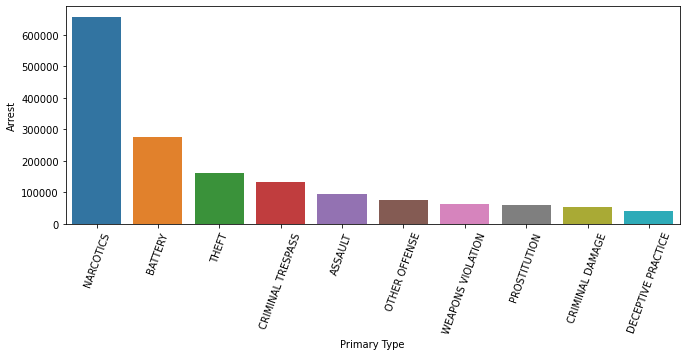

In [ ]:
fig=plt.figure(figsize=(11, 4))
top_15_arrestos = tipo_arresto[:10]
sns.barplot(top_15_arrestos.index, top_15_arrestos)
plt.xticks(rotation=70);

In [ ]:
arrestos_por_año = df.groupby('Year')['Arrest'].sum()

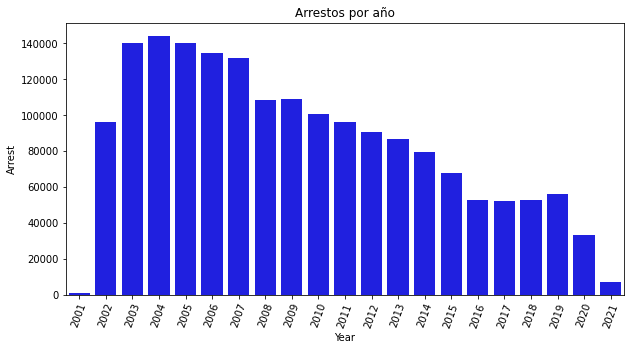

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(arrestos_por_año.index, arrestos_por_año, color="b")
degrees = 70  # Adjust according to one's preferences/needs
ax.set_title('Arrestos por año')
plt.xticks(rotation=degrees);

In [ ]:
#df['Date']
arrestos_mes = df[['Date', 'Arrest']].groupby(pd.Grouper(key='Date',freq='M')).sum().reset_index()

In [ ]:
def filtrar_años(n):
  return arrestos_mes[arrestos_mes['Date'].dt.year == n] #'2020'

In [ ]:
arrestos_2003 = filtrar_años(2003)
arrestos_2004 = filtrar_años(2004)
arrestos_2014 = filtrar_años(2014)
arrestos_2015 = filtrar_años(2015)
arrestos_2016 = filtrar_años(2016)
arrestos_2017 = filtrar_años(2017)
arrestos_2018 = filtrar_años(2018)
arrestos_2019 = filtrar_años(2019)
arrestos_2020 = filtrar_años(2020)
arrestos_2021 = filtrar_años(2021)

In [ ]:
arrestos_mes.describe()

,Arrest
count,244.000000
mean,7294.385246
std,3505.028425
min,37.000000
25%,4583.250000
50%,7557.500000
75%,10437.000000
max,13397.000000


In [ ]:
arrestos_mes[arrestos_mes.Arrest == 13397]

,Date,Arrest
33,2003-10-31,13397


In [ ]:
arrestos_2021

,Date,Arrest
240,2021-01-31,2173
241,2021-02-28,1758
242,2021-03-31,2094
243,2021-04-30,1065


Text(0.5, 1.0, 'Arrstos por Año en Chicago')

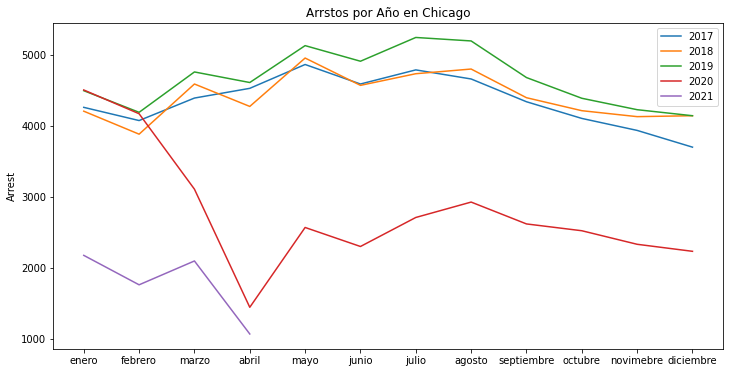

In [ ]:
fig = plt.figure(figsize=(12,6))
meses = ['enero', 'febrero', 'marzo', 'abril','mayo', 'junio', 'julio', 
         'agosto', 'septiembre', 'octubre','novimebre', 'diciembre']
sns.lineplot(x=meses, y=arrestos_2017['Arrest'], label='2017')
sns.lineplot(x=meses, y=arrestos_2018['Arrest'], label='2018')
sns.lineplot(x=meses, y=arrestos_2019['Arrest'], label='2019')
sns.lineplot(x=meses, y=arrestos_2020['Arrest'], label='2020')
ax = sns.lineplot(x=['enero','febrero','marzo','abril'], y=arrestos_2021['Arrest'], label='2021')

ax.set_title('Arrestos por Año en Chicago')

#  Exploración de variables categoricas

In [ ]:
# Aplicarlo por año generar un histograma 
#df.groupby('Block')['Arrest'].value_counts() 
df_cat = df[df['Date'].dt.year >= 2020]
df2 = pd.crosstab(df_cat['Date'], df_cat['Arrest']) 
df2

Arrest,0,1
Date,,
2020-01-01 00:00:00,53,3
2020-01-01 00:01:00,37,0
2020-01-01 00:02:00,1,0
2020-01-01 00:04:00,1,0
2020-01-01 00:05:00,0,2
...,...,...
2021-04-17 23:30:00,1,0
2021-04-17 23:45:00,1,0
2021-04-17 23:46:00,1,0


(array([737425., 737485., 737546., 737607., 737669., 737730., 737791.,
        737850., 737911.]), <a list of 9 Text major ticklabel objects>)

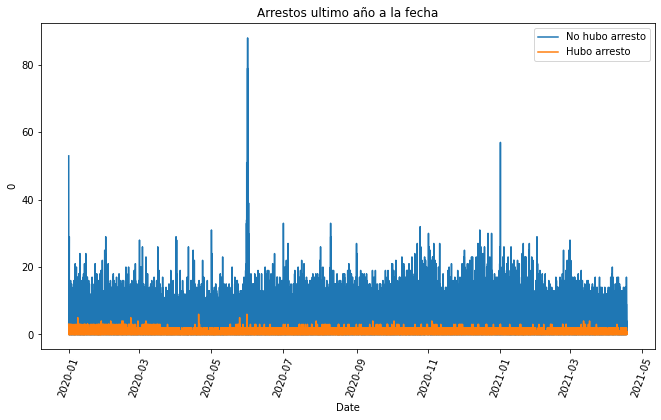

In [ ]:
fig = plt.figure(figsize=(11,6))
sns.lineplot(df2.index, df2[0], label='No hubo arresto')
ax=sns.lineplot(df2.index, df2[1], label='Hubo arresto')
ax.set_title('Arrestos ultimo año a la fecha')
plt.xticks(rotation = 70)

# Modelo De Regresión Lineal

Diversos estudios han encontrado una relación entre el crimen y las condiciones climáticas locales (1), se intentará predecir el número de crímenes reportados en chicago con la temperatura y humedad de cada día.


*1.- [Rodrigo Murataya, Ph.D.. (Mayo 2013). Effects of Weather on Crime. International Journal of Humanities and Social Science, 3, 5.](http://www.ijhssnet.com/journals/Vol_3_No_10_Special_Issue_May_2013/7.pdf)*

## Importación y preparación de los datos
Se ha extraído el regístro histórico de las temperaturas de Chicago mediante una api de la **[National Oceanic and Atmospheric Administration](https://www.ncdc.noaa.gov/cdo-web/webservices/v2#dataCategories).**
El proceso de extracción se realizó en un [Jupyter Notebook](https://github.com/EduHdzVillasana/Analisis_Crimen_Chicago_BEDU/blob/main/Extracci%C3%B3n%20Temperatura.ipynb) independiente de este.

In [ ]:
mainpath = "/content/drive/MyDrive/Datos Análisis del Crimen en Chicago/"
filename = "Chicago_Weather_Crimes.csv"
df_crimes_temp = pd.read_csv(os.path.join(mainpath, filename), index_col=0)
df_crimes_temp.head(3)

,Date,Total_Crimes,Temperature
0,2001-01-01,274,-10.871429
1,2001-01-02,10,-13.257143
2,2001-01-03,4,-6.585714


Text(0.5, 0, 'Crímenes Reportados')

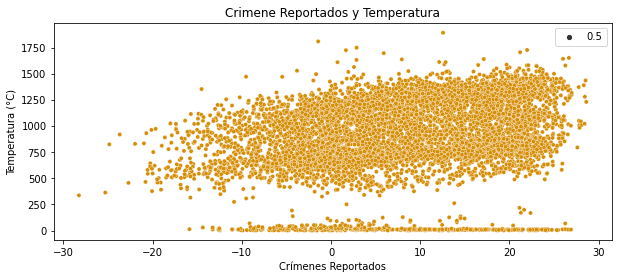

In [ ]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot()
sns.scatterplot(df_crimes_temp["Temperature"], df_crimes_temp["Total_Crimes"], ax = ax, size = .5, color="#D68E07", alpha = 1, linewidths = 0)
ax.set_title("Crimene Reportados y Temperatura")
ax.set_ylabel("Temperatura (°C)")
ax.set_xlabel("Crímenes Reportados")
#sns.scatterplot(df_crimes_temp["Temperature"], df_crimes_temp["Total_Crimes"])

Text(0.5, 1.0, 'BoxPlot de Crímenes Diarios')

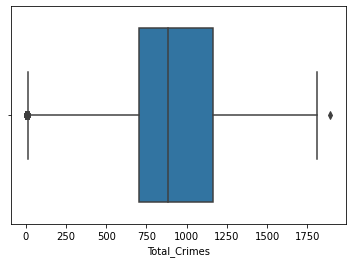

In [ ]:
sns.boxplot(df_crimes_temp["Total_Crimes"])
ax.set_title('BoxPlot de Crímenes Diarios');

En la gráfica de dispersión se puede ver claramente que hay datos que se separan de la mayoria, los días que tienen menos de 250 crímenes, pero en el boxplot no se ven muchos outliers ya que la cantidad de outliers que vemos en la gráfica de disperción es la suficiente para que no se consideren valores atípicos por el método del IQR.

In [ ]:
df_crimes_temp = df_crimes_temp[df_crimes_temp["Total_Crimes"] > 250]

In [ ]:
data_summary = summary(df_crimes_temp["Total_Crimes"])
data_summary

{'IQR': 448.0,
 'Q1': 734.0,
 'Q2': 923.0,
 'Q3': 1182.0,
 'max': 1893,
 'media': 953.5109478536444,
 'mediana': 923.0,
 'minimo': 251,
 'std': 270.2622840065848}

In [ ]:
IQR = data_summary["IQR"]
Q1 = data_summary["Q1"]
Q2 = data_summary["Q2"]
Q3 = data_summary["Q3"]

In [ ]:
df_crimes_temp = df_crimes_temp[(df_crimes_temp["Total_Crimes"] >= Q1 - 1.5*IQR)
                                & (df_crimes_temp["Total_Crimes"] <= Q3 + 1.5*IQR)]

In [ ]:
scaled = preprocessing.MinMaxScaler()
scaled_temp = scaled.fit_transform(df_crimes_temp["Temperature"].values.reshape(-1,1))
df_crimes_temp["Temperature"] = scaled_temp

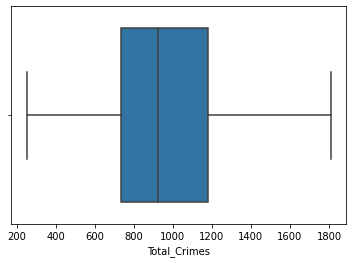

In [ ]:
sns.boxplot(df_crimes_temp["Total_Crimes"])
ax.set_title('BoxPlot de Crímenes Diarios');

Text(0.5, 0, 'Crímenes Reportados')

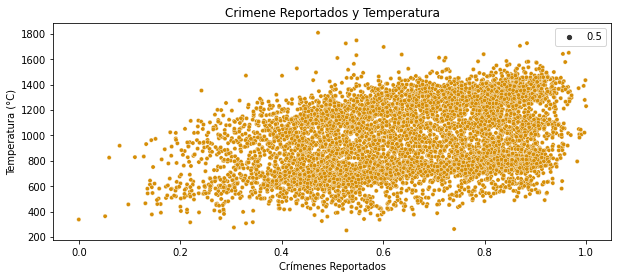

In [ ]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot()
sns.scatterplot(df_crimes_temp["Temperature"], df_crimes_temp["Total_Crimes"], ax = ax, size = .5, color="#D68E07", alpha = 1, linewidths = 0)
ax.set_title("Crimene Reportados y Temperatura")
ax.set_ylabel("Temperatura (°C)")
ax.set_xlabel("Crímenes Reportados")
#sns.scatterplot(df_crimes_temp["Temperature"], df_crimes_temp["Total_Crimes"])

## Separación de los datos en conjunto de Entrenamiento y Prueba

In [ ]:
X = df_crimes_temp["Temperature"]
y = df_crimes_temp["Total_Crimes"]

In [ ]:
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [ ]:
# Ya que sólo se tiene una variable se tiene que redimencionar el conjunto X
X = np.array(X).reshape(-1, 1)
X_training = np.array(X_training).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1, 1)

## Validación Cruzada

In [ ]:
lr = LinearRegression()

In [ ]:
scores = cross_validate(lr, X, y, scoring='r2')

In [ ]:
scores

{'fit_time': array([0.03739786, 0.00222325, 0.00125217, 0.00109839, 0.00107384]),
 'score_time': array([0.00096703, 0.00091219, 0.00055242, 0.00063682, 0.00058222]),
 'test_score': array([-5.75498997, -2.6837727 ,  0.28070318, -8.562443  , -9.30478655])}

In [ ]:
print(f'Score del modelo: {scores["test_score"].mean():.3f} +/- {scores["test_score"].std():.3f}')

Score del modelo: -5.205 +/- 3.601


## Entrenamiento del modelo de regresión lineal

In [ ]:
lr = LinearRegression()
lr.fit(X_training, y_training)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
lr.score(X_test, y_test)

0.10905587947245733

Se puede observar gráficamente que hay una tendencia en que entre más temperatura ambiental más crimenes habrá en el día, sin embargo a la hora de hacer una regresión lineal esta reflejo la relación aparente, se cree que se necesitan explorar la relación entre los crímenes y más datos meteorológicos como humedad, precipitaciones, preción atmosférica e incluse la fase lunar.

# Intento de Regresión Logista (Status: Probando si es util su aplicación)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [ ]:
X = df[['Beat','District', 'Ward', 'Community Area']]
y = df.Arrest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
# Create an instance of Logistic Regression Classifier and fit the data.
logreg = LogisticRegression(C=1e5)

In [ ]:
logreg.fit(X_train,y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Ya que tenemos un modelo, podemos hacer predicciones utilizando el dataset de prueba:

y_predict = logreg.predict(X_test)

In [ ]:
logreg.score(X_test, y_test)

0.7311171380393999

In [ ]:
from sklearn import metrics

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_predict)
cnf_matrix

array([[1453814,       0],
       [ 534669,       0]])

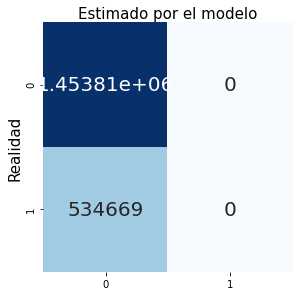

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots(figsize=(4, 4))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g', cbar=False, annot_kws={"size": 20})
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel('Realidad', fontsize=15, y=0.5)
plt.xlabel('Estimado por el modelo', fontsize=15);

In [ ]:
tn, fp, fn, tp = cnf_matrix.ravel()

print("Precision:",metrics.precision_score(y_test, y_predict))
print("Exactitud:",metrics.accuracy_score(y_test, y_predict))
print("Sensibilidad:",metrics.recall_score(y_test, y_predict))
print("Especificidad:", tn / (tn + fp))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0
Exactitud: 0.7311171380393999
Sensibilidad: 0.0
Especificidad: 1.0


In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
y_pred_proba = logreg.predict_proba(X_test)

y_pred_proba[:10,:]

array([[0.74211869, 0.25788131],
       [0.72646792, 0.27353208],
       [0.73556175, 0.26443825],
       [0.73639319, 0.26360681],
       [0.73565721, 0.26434279],
       [0.72980019, 0.27019981],
       [0.726377  , 0.273623  ],
       [0.736931  , 0.263069  ],
       [0.73487416, 0.26512584],
       [0.7380835 , 0.2619165 ]])

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

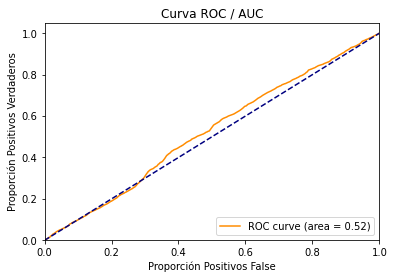

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Proporción Positivos False')
plt.ylabel('Proporción Positivos Verdaderos')
plt.title('Curva ROC / AUC')
plt.legend(loc="lower right")
plt.show()

## Visualización de Datos Avanzada

In [ ]:
pip install --upgrade plotly
import plotly.express as px

     |████████████████████████████████| 13.2MB 242kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
abc = df.groupby(['District','Primary Type','Arrest'])["ID"].count()
abc = abc.reset_index()
abc.rename(columns={'ID':'Count'}, inplace=True)

In [ ]:
fig = px.treemap(abc, path=['District', 'Primary Type','Arrest'], values='Count')

fig.show()

In [ ]:
distrito_conteo = pd.DataFrame()
distrito_conteo["conteo"] = df.groupby("District")["ID"].count()
distrito_conteo["District"] = ["001", "002", "003", "004", "005", "006", "007", "008", "009", "010", "011", "012", "014",
                               "015", "016", "017", "018", "019", "020", "022", "024", "025"]

In [ ]:
import folium

state_geo = f'https://opendata.arcgis.com/datasets/0b2f69d9383f477889302b7d654f224d_0.geojson'
state_data = distrito_conteo

m = folium.Map(location=[41.85, -87.7], zoom_start=10, width='70%', height='70%')

choropleth = folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['District', 'conteo'],
    key_on='feature.properties.DISTRICT',
    fill_color='YlOrRd',
    fill_opacity=0.8,
    line_opacity=0.2,
    highlight=True,
    legend_name='Conteo de delitos'
).add_to(m)

folium.LayerControl().add_to(m)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['NAME'],labels=False)
)
m

m

In [ ]:
arrestos_distrito = df.groupby("District")["Arrest"].value_counts().unstack(1)
arrestos_distrito = arrestos_distrito.sort_values(0, ascending=False)

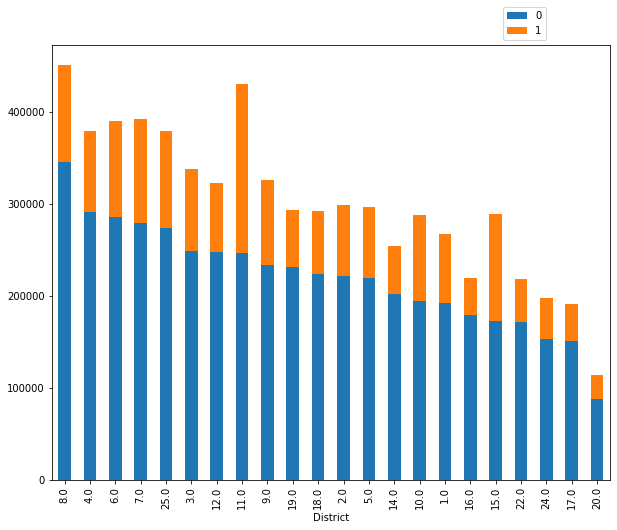

In [ ]:
arrestos_distrito.plot(kind="bar",stacked=True,figsize=(10,8))
plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
plt.show()

In [ ]:
sub_df = df[["Latitude", "Longitude", "Arrest", "Primary Type"]]
arresto_1 = sub_df[sub_df["Arrest"] == 1]
arresto_2 = arresto_1[arresto_1["Primary Type"] == "PUBLIC PEACE VIOLATION"]
arresto_3 = arresto_1[arresto_1["Primary Type"] == "MOTOR VEHICLE THEFT"]
arresto_4 = arresto_1[arresto_1["Primary Type"] == "HOMICIDE"]
arresto_5 = arresto_1[arresto_1["Primary Type"] == "ROBBERY"]

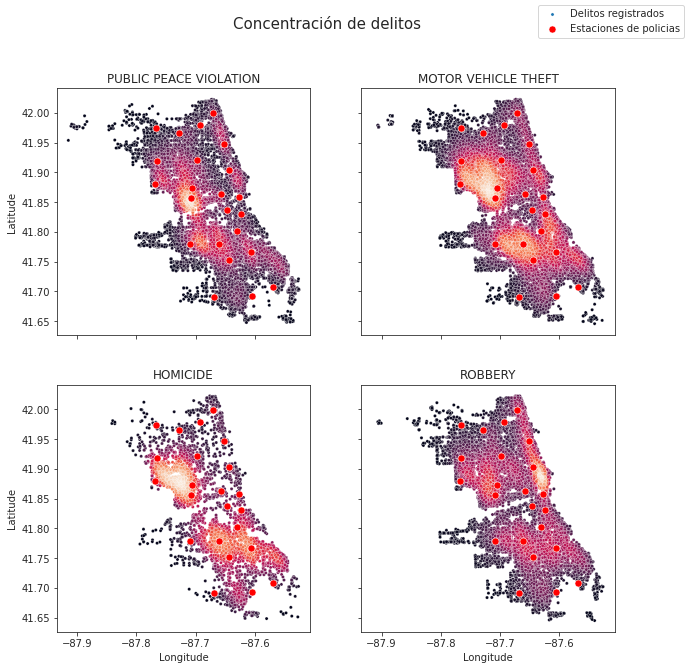

In [ ]:
from scipy.stats import gaussian_kde

fig = plt.figure(figsize=(10, 10))
axes = fig.subplots(2, 2, sharex=True, sharey=True)

xy = np.vstack([arresto_2['Longitude'], arresto_2['Latitude']])
z = gaussian_kde(xy)(xy)

xy2 = np.vstack([arresto_3['Longitude'], arresto_3['Latitude']])
z2 = gaussian_kde(xy2)(xy2)

xy3 = np.vstack([arresto_4['Longitude'], arresto_4['Latitude']])
z3 = gaussian_kde(xy3)(xy3)

xy4 = np.vstack([arresto_5['Longitude'], arresto_5['Latitude']])
z4 = gaussian_kde(xy4)(xy4)

sns.scatterplot(arresto_2['Longitude'], arresto_2['Latitude'], ax=axes[0, 0], c=z,  s=10)
sns.scatterplot(arresto_3['Longitude'], arresto_3['Latitude'], ax=axes[0, 1], c=z2, s=10)
sns.scatterplot(arresto_4['Longitude'], arresto_4['Latitude'], ax=axes[1, 0], c=z3, s=10)
sns.scatterplot(arresto_5['Longitude'], arresto_5['Latitude'], ax=axes[1, 1], c=z4, s=10)

axes[0, 0].set_title('PUBLIC PEACE VIOLATION')
axes[0, 1].set_title('MOTOR VEHICLE THEFT')
axes[1, 0].set_title('HOMICIDE')
axes[1, 1].set_title('ROBBERY')

sns.scatterplot(estacion_policias_clean['longitude'], estacion_policias_clean['latitude'], ax=axes[0,0], s=50, color='red');
sns.scatterplot(estacion_policias_clean['longitude'], estacion_policias_clean['latitude'], ax=axes[0,1], s=50, color='red');
sns.scatterplot(estacion_policias_clean['longitude'], estacion_policias_clean['latitude'], ax=axes[1,0], s=50, color='red');
sns.scatterplot(estacion_policias_clean['longitude'], estacion_policias_clean['latitude'], ax=axes[1,1], s=50, color='red');

fig.suptitle("Concentración de delitos", fontsize=15)
fig.legend(labels=["Delitos registrados", "Estaciones de policias"])

## Machine Learning

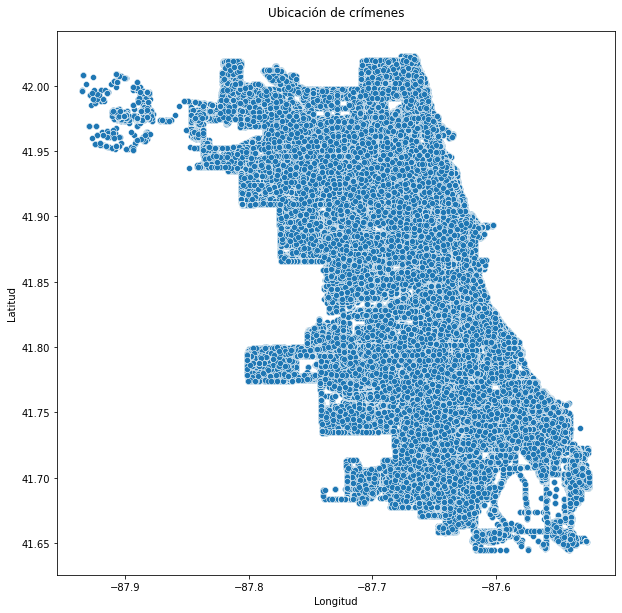

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()

ax.set_title('Ubicación de crímenes', pad=15)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

sns.scatterplot(df['Longitude'], df['Latitude'], ax=ax);

In [11]:
estacion_policias = pd.read_json("https://data.cityofchicago.org/resource/gkur-vufi.json")
location = estacion_policias["location"].apply(pd.Series).astype(float)
estacion_policias_clean = pd.concat([estacion_policias["district"], location["latitude"], location["longitude"]], axis=1)
#estacion_policias_clean

In [12]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=23, max_iter=1000)
k_means.fit(df[['Longitude', 'Latitude']])
centers = k_means.cluster_centers_

clasificaciones = k_means.predict(df[['Longitude', 'Latitude']])

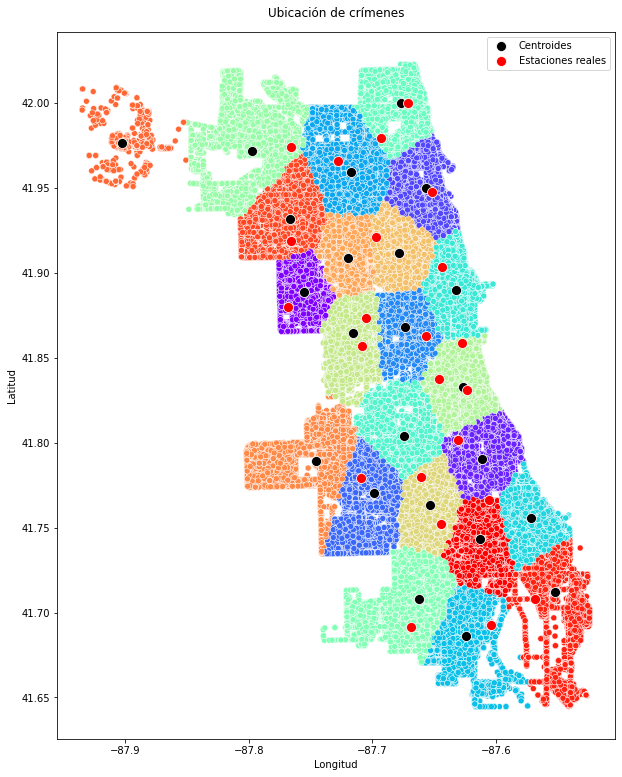

In [13]:
fig = plt.figure(figsize=(10,13))
ax = fig.add_subplot()

ax.set_title('Ubicación de crímenes', pad=15)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

#Delitos registrados
sns.scatterplot(df['Longitude'], df['Latitude'], hue=clasificaciones, palette='rainbow', legend=False);

#Centroides K_means - Negro
sns.scatterplot(centers[:,0], centers[:,1], ax=ax, s=100, color='black', label="Centroides");

#Estaciones de policia reales - Rojo
sns.scatterplot(estacion_policias_clean['longitude'], estacion_policias_clean['latitude'], ax=ax, s=100, color='red', label="Estaciones reales");

# Procesamiento de lenguaje natural

In [ ]:
df['Description'].unique()

array(['DOMESTIC BATTERY SIMPLE', 'POCKET-PICKING',
       'POSS: HEROIN(BRN/TAN)', 'SIMPLE', 'FORCIBLE ENTRY',
       'UNLAWFUL ENTRY', 'RETAIL THEFT', 'STRONGARM - NO WEAPON',
       '$500 AND UNDER', 'TELEPHONE THREAT', 'OVER $500',
       'AGGRAVATED DOMESTIC BATTERY: OTHER DANG WEAPON', 'TO VEHICLE',
       'TO PROPERTY', 'ARMED: HANDGUN', 'FROM BUILDING',
       'AGGRAVATED: OTHER DANG WEAPON', 'HARASSMENT BY TELEPHONE',
       'OTHER VEHICLE OFFENSE', 'PAROLE VIOLATION',
       'POSS: CANNABIS 30GMS OR LESS', 'UNLAWFUL USE OTHER DANG WEAPON',
       'GUN OFFENDER: ANNUAL REGISTRATION',
       'POSS FIREARM/AMMO:NO FOID CARD', 'COUNTERFEIT CHECK',
       'MANU/DELIVER: HEROIN (WHITE)', 'UNLAWFUL POSS OTHER FIREARM',
       'UNLAWFUL USE HANDGUN', 'TO LAND', 'AUTOMOBILE',
       'HARASSMENT BY ELECTRONIC MEANS', 'FRAUD OR CONFIDENCE GAME',
       'POSS: CRACK', 'AGGRAVATED:KNIFE/CUTTING INSTR', 'ATTEMPT THEFT',
       'SOLICIT NARCOTICS ON PUBLICWAY', 'POSS: HEROIN(WHITE)',
      

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df_nlp = df.Description
df_nlp = df_nlp.str.lower()
df_nlp = df_nlp.str.strip()
df_nlp = df_nlp.str.replace('[^\w\s]', '')
df_nlp = df_nlp.str.replace('\d', '')
df_nlp = df_nlp.str.replace('\\n', '')
df_nlp = df_nlp.dropna()

df_nlp_location = df['Location Description']
df_nlp_location = df_nlp_location.str.lower()
df_nlp_location = df_nlp_location.str.strip()
df_nlp_location = df_nlp_location.str.replace('[^\w\s]', '')
df_nlp_location = df_nlp_location.str.replace('\d', '')
df_nlp_location = df_nlp_location.str.replace('\\n', '')
df_nlp_location = df_nlp_location.dropna()

In [ ]:
df_nlp_sample = df_nlp.sample(100000)
df_nlp_location_sample = df_nlp_location.sample(50)

In [ ]:
# separamos cada oración en palabras
tokenized = df_nlp_sample.apply(nltk.word_tokenize)

In [ ]:
#tokenized2 = df_nlp_location.apply(nltk.word_tokenize)

In [ ]:
all_words = tokenized.sum()
#all_words2 = tokenized2.sum()

english_stop_words = stopwords.words('english')
all_words_except_stop_words = [word for word in all_words if word not in english_stop_words]
#all_words_except_stop_words2 = [word for word in all_words2 if word not in english_stop_words]

freq_dist = nltk.FreqDist(all_words_except_stop_words)
#freq_dist2 = nltk.FreqDist(all_words_except_stop_words2)

In [ ]:
most_common_20 = np.array(list(map(lambda x: list(x), freq_dist.most_common(20))))
y = np.array(most_common_20[:,1], dtype=int)

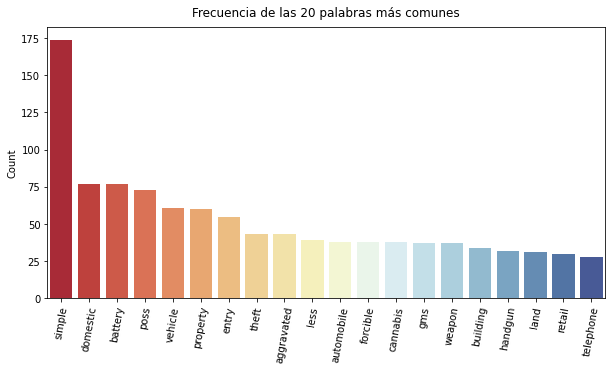

In [ ]:
# Podemos visualizar la frecuencia de las palabras más comunes
fig = plt.figure(figsize=(10,5  ))
ax = fig.add_subplot()

sns.barplot(most_common_20[:, 0], y, ax=ax, palette='RdYlBu');
ax.set_title('Frecuencia de las 20 palabras más comunes', pad=10)
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=80)

In [ ]:
most_common_50 = np.array(list(map(lambda x: list(x), freq_dist.most_common(50))))
y = np.array(most_common_50[:,1], dtype=int)

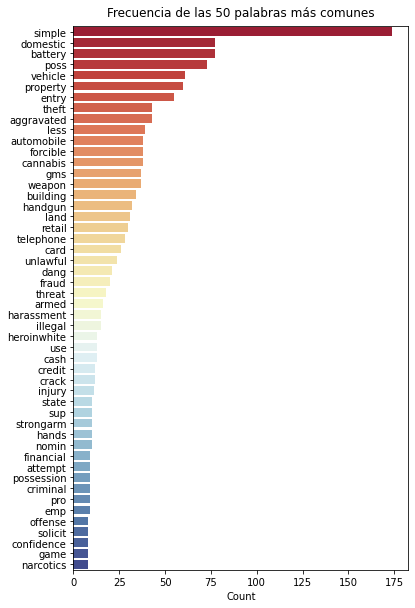

In [ ]:
most_common_50 = np.array(list(map(lambda x: list(x), freq_dist.most_common(50))))

fig = plt.figure(figsize=(6, 10))
ax = fig.add_subplot()

sns.barplot(y, most_common_50[:, 0], ax=ax, palette='RdYlBu', orient='h');
ax.set_title('Frecuencia de las 50 palabras más comunes', pad=10)
ax.set_xlabel('Count');

In [ ]:
all_words_except_stop_words = [word for word in all_words if word not in english_stop_words]
freq_dist_no_stop_words = nltk.FreqDist(all_words_except_stop_words)

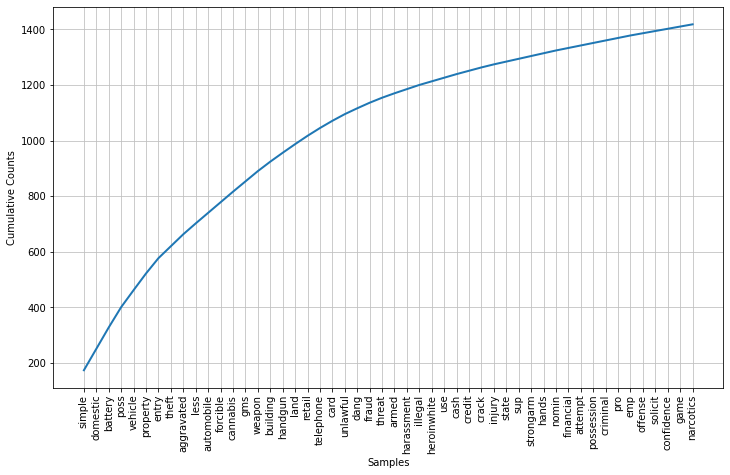

In [ ]:
# Veamos qué proporción del text está siendo ocupada por las 50 palabras más comunes
fig = plt.figure(figsize=(12,7))
freq_dist_no_stop_words.plot(50, cumulative=True);

In [ ]:
# También podemos visualizar la frecuencia de los bigramas más comunes

text = nltk.Text(all_words)
freq_dist_bigrams = nltk.FreqDist(list(nltk.bigrams(text)))

freq_dist_bigrams

FreqDist({('a', 'computer'): 1,
          ('abuse', 'and'): 2,
          ('abuse', 'by'): 1,
          ('abuse', 'credit'): 1,
          ('abuse', 'domestic'): 2,
          ('abuse', 'manudelcannabis'): 1,
          ('abuseneglect', 'reckless'): 1,
          ('add', 'armed'): 1,
          ('against', 'person'): 1,
          ('agg', 'financial'): 1,
          ('agg', 'po'): 1,
          ('agg', 'proemp'): 1,
          ('agg', 'sex'): 1,
          ('aggravated', 'criminal'): 1,
          ('aggravated', 'domestic'): 9,
          ('aggravated', 'forcible'): 1,
          ('aggravated', 'handgun'): 14,
          ('aggravated', 'knife'): 1,
          ('aggravated', 'other'): 16,
          ('aggravated', 'to'): 1,
          ('aggravatedknifecutting', 'instr'): 8,
          ('and', 'under'): 99,
          ('animal', 'abuseneglect'): 1,
          ('armed', 'handgun'): 14,
          ('armed', 'other'): 2,
          ('armedhandgun', 'simple'): 1,
          ('armedhandgun', 'theftrecovery'): 1,
   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


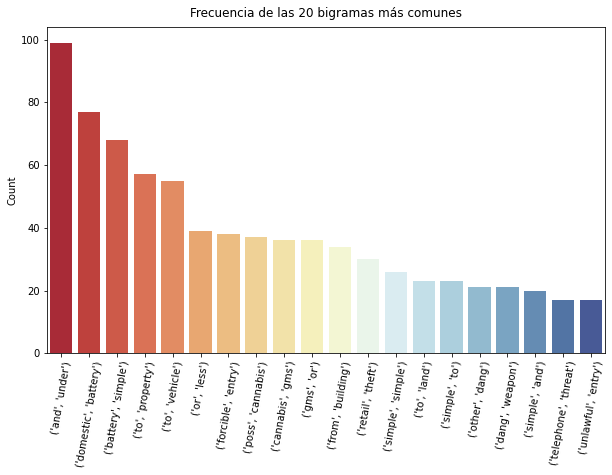

In [ ]:
most_common_20 = np.array(list(map(lambda x: list(x), freq_dist_bigrams.most_common(20))))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

sns.barplot(most_common_20[:, 0], most_common_20[:, 1], ax=ax, palette='RdYlBu');
ax.set_title('Frecuencia de las 20 bigramas más comunes', pad=10)
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=80)

In [ ]:
# Probemos sin palabras vacías

text = nltk.Text(all_words_except_stop_words)
freq_dist_bigrams = nltk.FreqDist(list(nltk.bigrams(text)))

freq_dist_bigrams

FreqDist({('abuse', 'aggravated'): 1,
          ('abuse', 'credit'): 1,
          ('abuse', 'domestic'): 2,
          ('abuse', 'family'): 1,
          ('abuse', 'manudelcannabis'): 1,
          ('abuse', 'poss'): 1,
          ('abuseneglect', 'reckless'): 1,
          ('add', 'armed'): 1,
          ('agg', 'financial'): 1,
          ('agg', 'po'): 1,
          ('agg', 'proemp'): 1,
          ('agg', 'sex'): 1,
          ('aggravated', 'criminal'): 1,
          ('aggravated', 'dang'): 14,
          ('aggravated', 'dangerous'): 2,
          ('aggravated', 'domestic'): 9,
          ('aggravated', 'forcible'): 1,
          ('aggravated', 'handgun'): 14,
          ('aggravated', 'knife'): 1,
          ('aggravated', 'property'): 1,
          ('aggravatedknifecutting', 'instr'): 8,
          ('animal', 'abuseneglect'): 1,
          ('armed', 'dangerous'): 2,
          ('armed', 'handgun'): 14,
          ('armedhandgun', 'simple'): 1,
          ('armedhandgun', 'theftrecovery'): 1,
         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


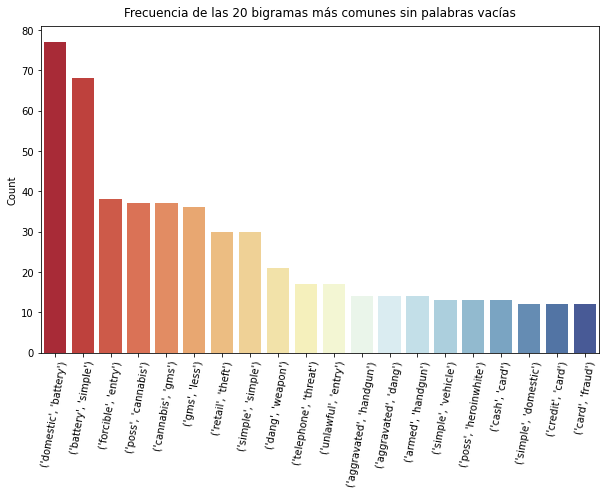

In [ ]:
most_common_20 = np.array(list(map(lambda x: list(x), freq_dist_bigrams.most_common(20))))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

sns.barplot(most_common_20[:, 0], most_common_20[:, 1], ax=ax, palette='RdYlBu');
ax.set_title('Frecuencia de las 20 bigramas más comunes sin palabras vacías', pad=10)
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=80)

In [ ]:
from nltk.util import ngrams

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


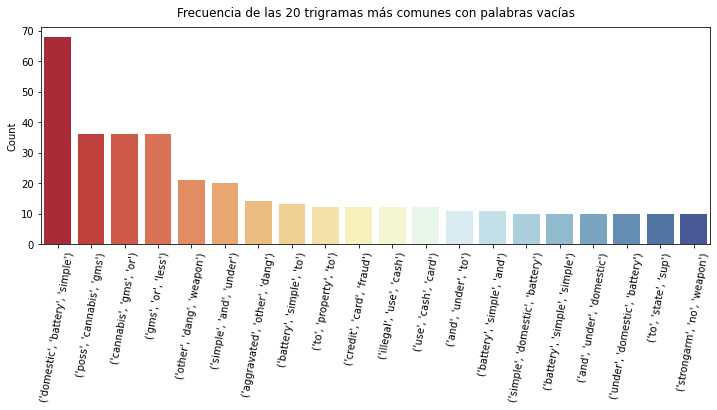

In [ ]:
text = nltk.Text(all_words)
freq_dist_trigrams = nltk.FreqDist(list(ngrams(text, 3)))

most_common_20 = np.array(list(map(lambda x: list(x), freq_dist_trigrams.most_common(20))))

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot()

sns.barplot(most_common_20[:, 0], most_common_20[:, 1], ax=ax, palette='RdYlBu');
ax.set_title('Frecuencia de las 20 trigramas más comunes con palabras vacías', pad=10)
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=80)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


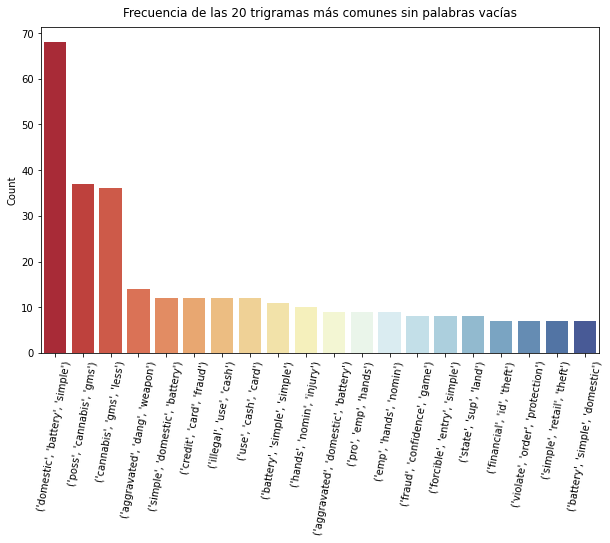

In [ ]:
text = nltk.Text(all_words_except_stop_words)
freq_dist_trigrams = nltk.FreqDist(list(ngrams(text, 3)))

most_common_20 = np.array(list(map(lambda x: list(x), freq_dist_trigrams.most_common(20))))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

sns.barplot(most_common_20[:, 0], most_common_20[:, 1], ax=ax, palette='RdYlBu');
ax.set_title('Frecuencia de las 20 trigramas más comunes sin palabras vacías', pad=10)
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=80)

In [ ]:
# También podemos generar histogramas para visualizar la frecuencia de longitudes de palabras y oraciones

word_lengths = [len(w) for w in all_words_except_stop_words]

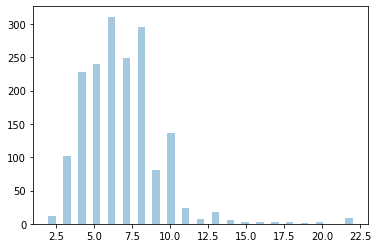

In [ ]:
sns.distplot(word_lengths, kde=False, norm_hist=False);

In [ ]:
from wordcloud import WordCloud

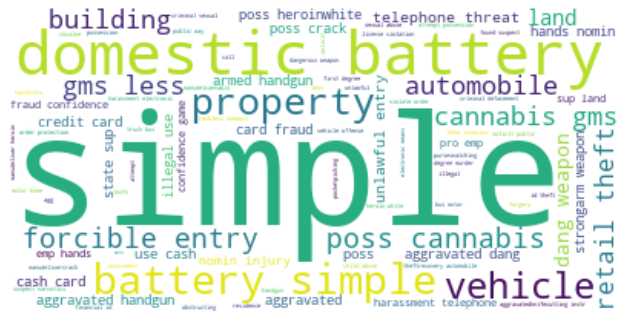

In [ ]:
wordcloud = WordCloud(max_font_size=100, background_color="white").generate(' '.join(all_words_except_stop_words))

plt.figure(figsize=(11, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
w = pd.DataFrame(all_words_except_stop_words)
w[0].str.contains('poss').sum()

9082